In [49]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget

In [50]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation

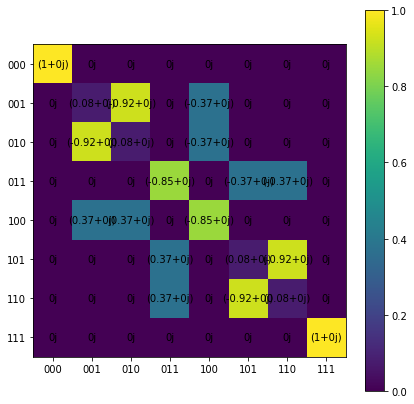

In [51]:
#using our same metrics as before using ratio of coupling strengths, investigate the relative costs of our 3Q gates
from src.hamiltonian import CirculatorHamiltonian
#v_nn = np.sqrt(2) * np.pi / np.arccos(1 / np.sqrt(3)) #w-state
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0]
#v_params = [np.pi / 2, np.pi / 2, np.pi / 2, np.pi / v_nn, np.pi / v_nn, np.pi / v_nn]
_array = CirculatorHamiltonian.construct_U(*v_params,t=1.6442677715360021) #w-state
#_array = CirculatorHamiltonian.construct_U(*v_params,t=1) #completed DIV
plotMatrix(_array);

In [52]:
#TODO XXX this code is written badly, needs to pass the entire circuit with a single parameter!!
from qiskit.circuit import Parameter


def foo(qc: QuantumCircuit):
    #pass in a parameterized quantum circuit, only parameter should be duration of the target unitary
    qc.parameters

qc = QuantumCircuit(3)
qc.x(1)
t_param = Parameter('t')
from src.utils.custom_gates import VSwap
qc.append(VSwap(t_param), [0,1,2])
qc.draw()

┌───────────┐
q_0: ─────┤0          ├
     ┌───┐│           │
q_1: ┤ X ├┤1 VSWAP(t) ├
     └───┘│           │
q_2: ─────┤2          ├
          └───────────┘

In [53]:
from qiskit import transpile, BasicAer, QuantumCircuit
logger.setLevel(logging.WARNING)
def foo_plot2(v_params):
    data = []
    cost_data = []
    unit_cost = sum(v_params[-3:])/(np.pi/2) # XXX the g-terms
    t_range = np.linspace(0,1,20)
    for t_el in t_range:
        qc = QuantumCircuit(3)

        #ghz from delta
        qc.h(1)
        qc.x(0)

        #w from delta
        #qc.x(1)

        #w from vswap
        #qc.x(2)
        

        unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
        qc.unitary(unitary, [0,1,2])

        #ghz from delta
        qc.x(1)
        
        #w from delta
        #qc.rz(4*np.pi/3, 1)


        #output_state = np.matmul(unitary.full(),np.array(input_state))
        backend = BasicAer.get_backend('statevector_simulator') # the device to run on
        result = backend.run(transpile(qc, backend)).result()
        output_state = result.get_statevector(qc)

        data.append([np.abs(el)**2 for el in output_state])
        cost_data.append(unit_cost*t_el)
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=r"$|$" + f"{bin(s_index)[2:].zfill(3)}" + r"$\rangle$", marker='.', dashes=(5, s_index))
    plt.plot(t_range, cost_data)
    plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("State Probability")
    plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])
    return qc

The Delta-iSwap is difficult to find entangled states for. Here is a costly GHZ-state:

final state: [0.4999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4999999999999999]


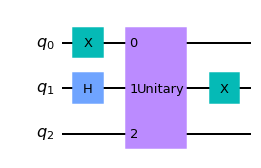

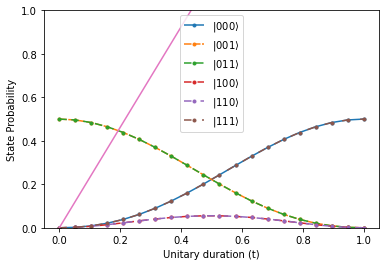

In [26]:
nn = 3 * np.sqrt(3) / 2
v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
foo_plot2(v_params).draw(output='mpl')

Here is a Delta-iSwap finding the W-state from Martinis paper

final state: [0.0, 0.22222222222222238, 0.22222222222222243, 0.0, 0.5555555555555554, 0.0, 0.0, 0.0]


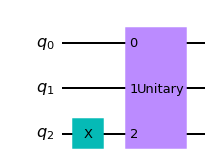

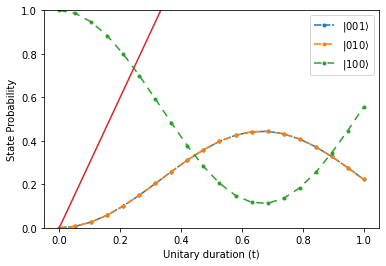

In [50]:
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [0, 0, 0, np.pi/2, np.pi/2, np.pi/2]
foo_plot2(v_params).draw(output='mpl')

The following V-iSwap gate is an interesting example because it shows both the W-State and the ~~GHZ-state created from the same input~~. My mistake, I saw 2 states go to equal probability, but this is not enough for a GHZ-state, needs to be |000> and |111> states specifically!

final state: [0.0, 0.5000000000000001, 0.5000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0]


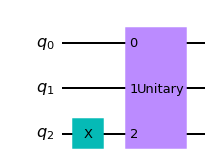

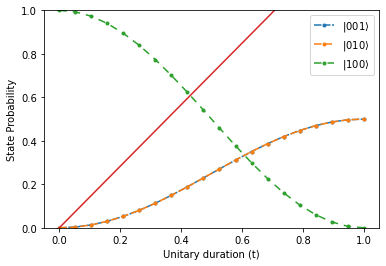

In [51]:
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
foo_plot2(v_params).draw(output='mpl')

It is difficult to know when we have the most cost-effective construction of an entangled state. A way to approach this problem differently, is to instead start with an entangled state, and run the gate while plotting mutual information - which should be 0 for a non-entangled state. This way we can observe states independent of 1Q gates, but by a pure measure of entanglement.

In [2]:
"""Use plots of mutual information to determine entanglement"""
#Idea: run the gate in reverse, and when mutual information is 0, no longer entangled
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
qc = QuantumCircuit(3)

from qiskit import transpile, BasicAer, QuantumCircuit
logger.setLevel(logging.WARNING)
def foo_plot3(v_params, prep_state='w'):
    data = []
    cost_data = []
    unit_cost = sum(v_params[-3:])/(np.pi/2) # XXX the g-terms
    t_range = np.linspace(0,1,40)
    for t_el in t_range:
        qc = QuantumCircuit(3)

        if prep_state =="ghz":
        # #GHZ-state prep
            qc.h(0)
            qc.cx(0, 1)
            qc.cx(0, 2)
        #######

        #W-state prep
        elif prep_state=="w":
            qc.ry(2*np.arccos(1/np.sqrt(3)),0)
            qc.ch(0,1)
            qc.cx(1,2)
            qc.cx(0,1)
            qc.x(0)
        else:
            raise("invalid prep state")
            
        #####
        #ghz from delta
        qc.x(1)
        
        #w from delta
        #qc.rz(4*np.pi/3, 1)
        
        unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
        qc.unitary(unitary, [0,1,2])

        #ghz from delta
        qc.h(1)
        qc.x(0)

        #w from delta
        #qc.x(1)

        #w from vswap
        #qc.x(2)
        

        state = Statevector(qc)
        state1 = partial_trace(state, [0])
        state2 = partial_trace(state, [1])
        state3 = partial_trace(state, [2])
        
        
        #data.append([mutual_information(state1), mutual_information(state2), mutual_information(state3)])
        #data.append([concurrence(state1), concurrence(state2), concurrence(state3)])
        #data.append([sum([entanglement_of_formation(state1), entanglement_of_formation(state2), entanglement_of_formation(state3)])])
        data.append([sum([mutual_information(state1), mutual_information(state2), mutual_information(state3)])])
        cost_data.append(unit_cost*t_el)
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=f"S{s_index}", marker='.', dashes=(5, s_index))
    plt.plot(t_range, cost_data)
    plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("Entanglement Monotone")
    #plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])
    print("best state:", t_range[np.argmin(data)], min(data))
    return qc

# backend = BasicAer.get_backend('statevector_simulator')
# result = backend.run(transpile(qc, backend)).result()
# output_state = result.get_statevector(qc)
# print(output_state)

# qc.measure_all()
# from qiskit.visualization import plot_histogram
# backend = BasicAer.get_backend('qasm_simulator')
# job = execute(qc, backend)
# plot_histogram(job.result().get_counts())

NameError: name 'np' is not defined

This plot shows at ~.6, the mutual informations all go to 1, this is where the W-state is created by this gate.

final state: [2.218340677351195]
best state: 0.6090225563909775 [7.487006119963555e-05]


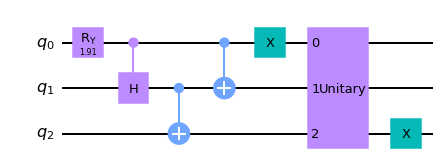

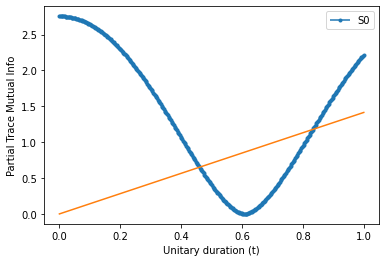

In [55]:
# foo_plot3(v_params) #GHZ state has this messy result
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
foo_plot3(v_params).draw(output='mpl')

final state: [1.9220559022889504e-15]
best state: 1.0 [1.9220559022889504e-15]


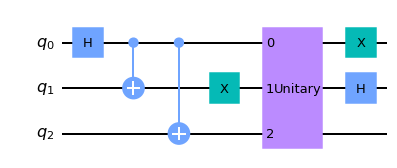

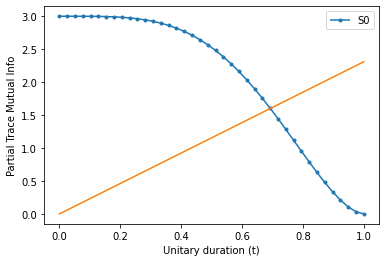

In [57]:
# foo_plot3(v_params) #GHZ state has this messy result
nn = 3 * np.sqrt(3) / 2
v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
foo_plot3(v_params, prep_state='ghz').draw(output='mpl')

Now I am going to try and combine entanglement with variational template. Use an entanglement monotone as the cost function

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation

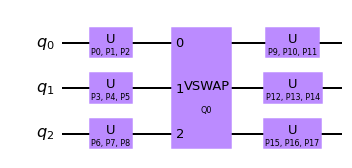

In [2]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import VSwap
basis = CircuitTemplateV2(n_qubits=3, base_gates = [VSwap], edge_params=[[(0,1,2)]])
basis.build(1)
basis.spanning_range = range(1,2)
basis.circuit.draw(output='mpl')

In [3]:
ub = 0.7
basis.add_constraint("Q0", min=0, max=ub)

In [4]:
from src.cost_function import MutualInformation, MutualInformationSquare
objective = MutualInformation()
from src.optimizer import TemplateOptimizer
optimizer = TemplateOptimizer(basis=basis, objective=objective, use_callback=True, override_fail=True)

Now note the optimzer for entanglement should ignore the sample since it isn't used in the cost function

In [5]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]
ret = optimizer.approximate_target_U(s)

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 1
INFO:root:Break on cycle 1
INFO:root:Loss=5.888149939055665e-13
INFO:root:Success: (0.49741881, 0.30805173, 0.042267)


Entangled Fidelity 5.888149939055665e-13


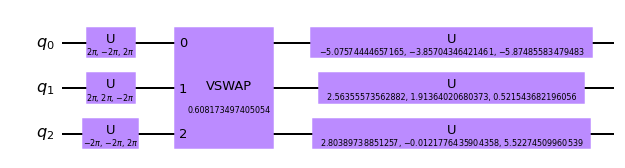

In [6]:
basis.build(ret.cycles)
circuit =basis.assign_Xk(ret.Xk)
print("Entangled Fidelity", ret.loss_result)
circuit.draw(output='mpl')

In [29]:
from qiskit.circuit import Parameter
def unbind_parameters(qc):
    out = qc.copy()
    for instr, qargs, cargs in out:
        if instr.params and instr.name =='vswap' or instr.name == "Δswap":
            # num_params = len(instr.params)
            # pvec.resize(len(pvec) + num_params)
            instr.params = [Parameter('t')]

    return out

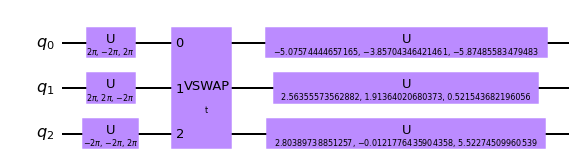

In [8]:
qc2 = circuit.copy()
qc3 = unbind_parameters(qc2)
#update parameter table
from qiskit.converters import *
qc3 = dag_to_circuit(circuit_to_dag(qc3))
# qc3.parameters
qc3.draw(output='mpl')

In [23]:
from src.cost_function import EntanglementCostFunction
def foo_plot4(qc_p, cost_function:EntanglementCostFunction):
    data = []
    t_range = np.linspace(0,1.5*ub,100)
    for t_el in t_range:
            
        qc2 = qc_p.assign_parameters(
            {parameter: i for parameter, i in zip(qc_p.parameters, [t_el])}
        )

        val = cost_function.entanglement_monotone(qc2)
        data.append([val])
     
    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, marker='.', dashes=(5, s_index))
    # plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("Entanglement Monotone")
    #plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("best state:", t_range[np.argmin(data)], min(data))
    return cost_function.full #returns the circuit for displaying

best state: 0.6060606060606061 [0.00040562468750360303]


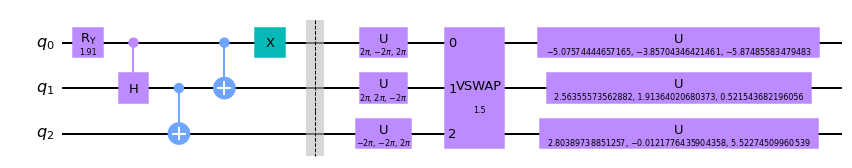

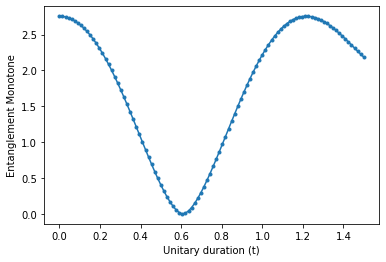

In [24]:
foo_plot4(qc3, cost_function=objective).draw(output='mpl')

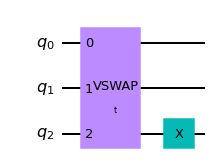

In [11]:
#compare against the known solution, defined backwards
qc_test = QuantumCircuit(3)
qc_test.append(VSwap(Parameter('t')), (0,1,2))
qc_test.x(2)
qc_test.draw(output='mpl')

best state: 0.6060606060606061 [0.000405624687502789]


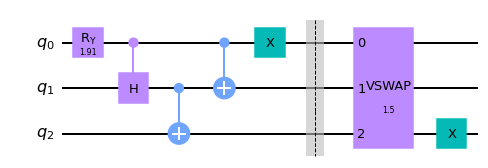

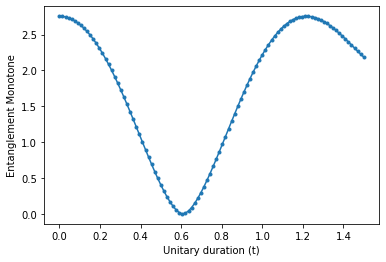

In [25]:
foo_plot4(qc_test, cost_function=objective).draw(output='mpl')

Now we want to see if the optimizer can create GHZ state using the DeltaSwap, because this was the most expensive one we foudn by hand

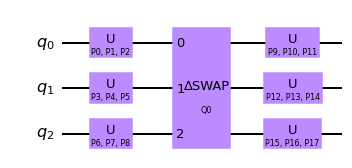

In [35]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import DeltaSwap
del_basis = CircuitTemplateV2(n_qubits=3, base_gates = [DeltaSwap], edge_params=[[(0,1,2)]])
del_basis.build(1)
del_basis.spanning_range = range(1,2)
del_basis.circuit.draw(output='mpl')

In [36]:
ub = 1.0
del_basis.add_constraint("Q0", min=0, max=ub)

In [37]:
from src.cost_function import MutualInformation, MutualInformationSquare
objective2 = MutualInformation(state='ghz')
from src.optimizer import TemplateOptimizer
optimizer2 = TemplateOptimizer(basis=del_basis, objective=objective2, use_callback=True, override_fail=True)

In [38]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]
ret2 = optimizer2.approximate_target_U(s)

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 1
INFO:root:Break on cycle 1
INFO:root:Loss=1.658526042310742e-11
INFO:root:Success: (0.49741881, 0.30805173, 0.042267)


Entangled Fidelity 1.658526042310742e-11


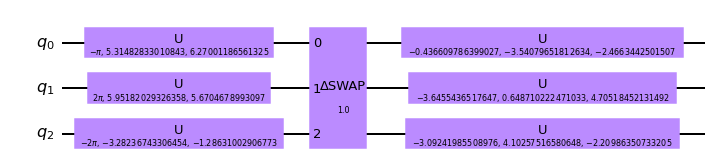

In [39]:
del_basis.build(ret2.cycles)
circuit2 =del_basis.assign_Xk(ret2.Xk)
print("Entangled Fidelity", ret2.loss_result)
circuit2.draw(output='mpl')

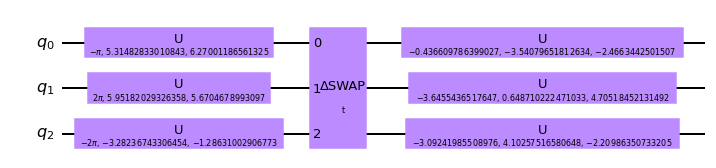

In [40]:
dqc2 = circuit2.copy()
dqc3 = unbind_parameters(dqc2)
#update parameter table
from qiskit.converters import *
dqc3 = dag_to_circuit(circuit_to_dag(dqc3))
# qc3.parameters
dqc3.draw(output='mpl')

best state: 1.0 [1.658526042310742e-11]


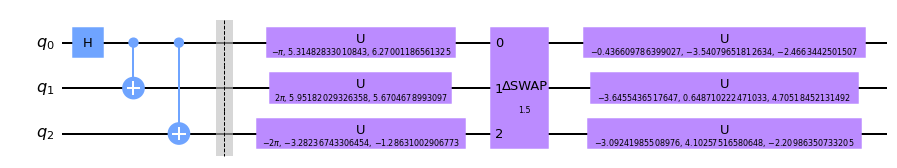

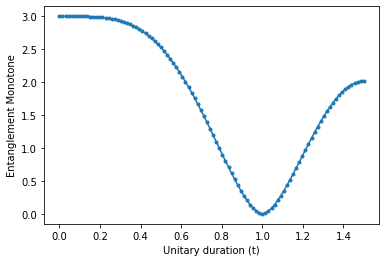

In [41]:
foo_plot4(dqc3, cost_function=objective2).draw(output='mpl')

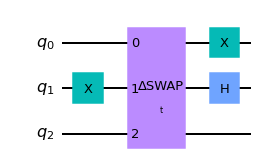

In [42]:
#compare against the known solution, backwards!
qc_test2 = QuantumCircuit(3)
qc_test2.x(1)
qc_test2.append(DeltaSwap(Parameter('t')), (0,1,2))
qc_test2.x(0)
qc_test2.h(1)
qc_test2.draw(output='mpl')

best state: 1.0 [1.9220559022889504e-15]


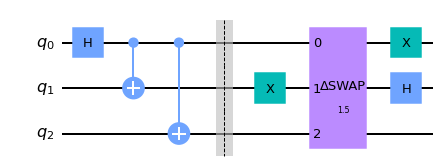

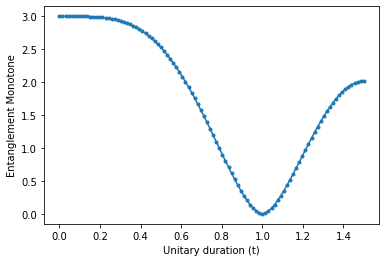

In [43]:
foo_plot4(qc_test2, cost_function=objective2).draw(output='mpl')

Now we have shown the optimizer can reproduce the 2 known solutions on the V- and Delta-iSwap gates, we want to give it the generic form of the 3Q gates possible and see if it can find a more optimal gate to build each W,GHZ entangled state. 

The major change is that we need a more detailed way to define cost. Before, when time is the only variable, we could just observe that for constant gate params, smaller time is better. Now that gate params are free to be optimized, we define a cost function.

Problem: how do we define a total process fidelity? When we did noisy decomps we could take the product of decompositon fidelity and circuit fidelity. Now, we aren't looking at decomposition fidelity - instead it is just some entangelment monotone so I'm not sure the product of these together is a valid new cost function. 

A straight foward but not practicle way to tackle multi-objective learning is to wrap our optimizer in 2 layers. We want to optimize the cost of the gate in outer loop, optimizer to check if there exists an entanglement solution is in the inside loop.

In [8]:
from src.utils.custom_gates import CirculatorSNAILGate

gate = CirculatorSNAILGate(0,0,0, np.pi/4, np.pi/4, 0, t_el=.5)
gate.cost()

0.9995

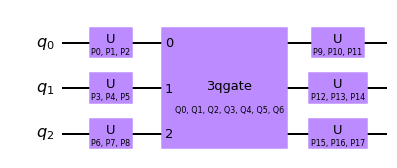

In [19]:
from src.basisv2 import CircuitTemplateV2
f_basis = CircuitTemplateV2(n_qubits=3, base_gates = [CirculatorSNAILGate], edge_params=[[(0,1,2)]])
f_basis.build(1)
f_basis.spanning_range = range(1,2)
f_basis.circuit.draw(output='mpl')